# Import essential library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from statsmodels.formula.api import ols
import statsmodels.api as sm
from sklearn.preprocessing import OneHotEncoder
import ast


# Import Dataset

In [2]:
data = pd.read_csv('./Datasets/Cleaned Grab SG Restaurants.csv')
data.head()

,name,address,cuisine,delivery_cost,lat,lon,opening_hours,radius,rating,reviews_nr,delivery_options,promo,loc_type,delivery_by,delivery_time,total opening time hours,weighted_rating
0,Texas Chicken,Texas Chicken - VivoCity,"[""Western"", ""Fast Food"", ""Halal"", ""Chicken"", ""...",570.0,1.264792,103.822103,"{""open"": true, ""displayedHours"": ""10:30-21:30""...",5000,3.8,1591.0,ONLY_DELIVERY,Use 'TEATIME' for FREE delivery between 3PM to...,FOOD,GRAB,43.0,75.75,3.871145
1,Subway,Subway - Vivocity,"[""Healthy"", ""Sandwiches"", ""Fast Food"", ""Halal""...",570.0,1.264741,103.822072,"{""open"": true, ""displayedHours"": ""12:00-19:00""...",3000,4.2,197.0,ONLY_DELIVERY,Use 'TEATIME' for FREE delivery between 3PM to...,FOOD,GRAB,42.0,49.00,4.227096
2,LiHO Tea,LiHO Tea - Vivo City,"[""Same Prices In-Store"", ""Beverages"", ""Local"",...",560.0,1.264309,103.821369,"{""open"": true, ""displayedHours"": ""11:30-20:45""...",5000,4.5,353.0,DELIVERY_TAKEAWAY,Use 'TEATIME' for FREE delivery between 3PM to...,FOOD,GRAB,41.0,64.75,4.382085
3,Wingstop,Wingstop - VivoCity,"[""Halal"", ""Chicken"", ""Fast Food"", ""Burger"", ""W...",560.0,1.263527,103.821712,"{""open"": true, ""displayedHours"": ""11:00-21:00""...",5000,4.4,1391.0,ONLY_DELIVERY,Use 'TEATIME' for FREE delivery between 3PM to...,FOOD,GRAB,45.0,70.00,4.372224
4,Le Shrimp Ramen,Le Shrimp Ramen - Vivocity,"[""Japanese"", ""Ramen"", ""Noodles"", ""Asian""]",570.0,1.264810,103.822554,"{""open"": true, ""displayedHours"": ""10:30-21:00""...",5000,4.6,309.0,DELIVERY_TAKEAWAY,Use 'TEATIME' for FREE delivery between 3PM to...,FOOD,GRAB,44.0,73.50,4.424098


## Delivery Time vs Weighted Rating

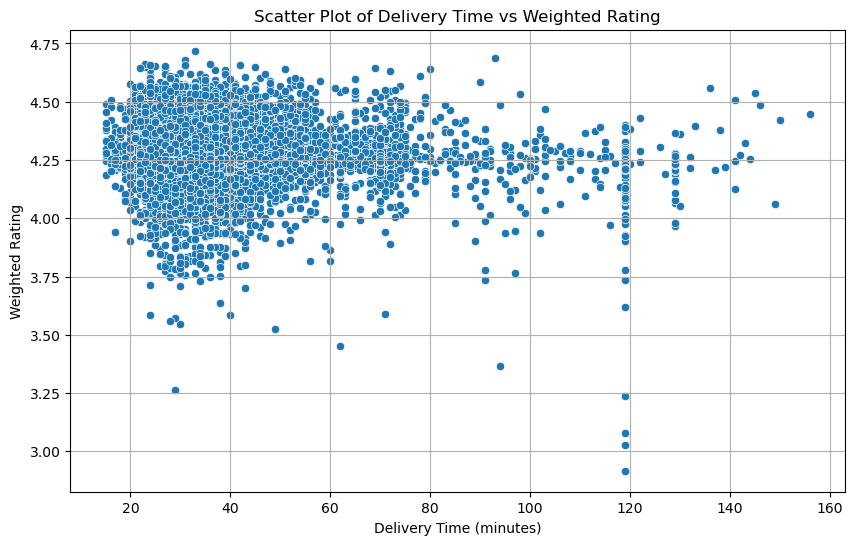

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot of delivery time versus weighted rating
plt.figure(figsize=(10, 6))
sns.scatterplot(x='delivery_time', y='weighted_rating', data=data)
plt.title('Scatter Plot of Delivery Time vs Weighted Rating')
plt.xlabel('Delivery Time (minutes)')
plt.ylabel('Weighted Rating')
plt.grid(True)
plt.show()


In [4]:
correlation = data['delivery_time'].corr(data['weighted_rating'])

print("correlation coefficient:", correlation)

correlation coefficient: -0.03681818875634128


In [5]:
# Drop rows with missing values in both 'delivery_time' and 'weighted_rating' columns
data_final = data.dropna(subset=['delivery_time', 'weighted_rating'])

# Prepare the data for regression once more
X_final = data_final[['delivery_time']]
y_final = data_final['weighted_rating']

# Split the data into training and testing sets again
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(X_final, y_final, test_size=0.2, random_state=42)

# Create and train the linear regression model
model_final = LinearRegression()
model_final.fit(X_train_final, y_train_final)

# Predict on the test set
y_pred_final = model_final.predict(X_test_final)

# Calculate MSE and R^2
mse_final = mean_squared_error(y_test_final, y_pred_final)
r2_final = r2_score(y_test_final, y_pred_final)

mse_final, r2_final


(0.012090439811617565, -0.003923430097376723)

## Evaluation of Linear Regression Model: Delivery Time vs Weighted Rating

### Mean Squared Error (MSE):
- **MSE**: 0.0121
  - The MSE is relatively low, indicating that the model's predictions are close to the actual data points on average. However, MSE alone does not provide a complete measure of model accuracy.

### Coefficient of Determination (R²):
- **R²**: -0.0039
  - The negative R² value suggests that the model fails to effectively explain the variation in `weighted_rating`. This implies that using this model is no better than using the mean of the observed responses as a predictor.

### General Analysis:
- The **negative R² value** highlights that a linear model might be inappropriate for this dataset, suggesting a lack of linear relationship between `delivery_time` and `weighted_rating`.
- **Delivery time** appears to be a poor predictor of weighted rating. This result points towards the need for considering other variables that could be more influential in determining the rating.
- The relationship between delivery time and weighted rating might be more complex than what can be captured by a simple linear model. Exploring **alternative models** or including **additional predictors** could potentially provide better insights.
- Considering **non-linear models** or different forms of regression analysis might yield more informative results about the dynamics influencing restaurant ratings.


# Total Opening Hours vs Weighted Rating

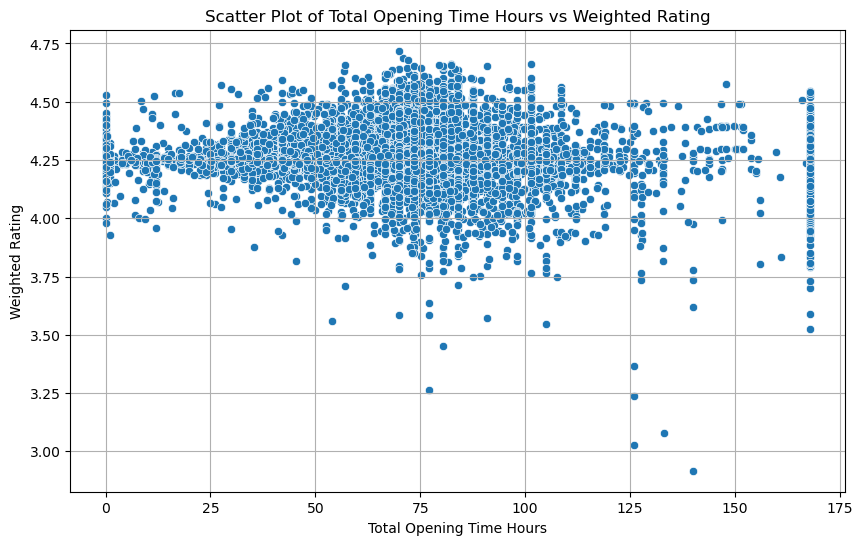

In [6]:
# Scatter plot of total opening time hours versus weighted rating
plt.figure(figsize=(10, 6))
sns.scatterplot(x='total opening time hours', y='weighted_rating', data=data_final)
plt.title('Scatter Plot of Total Opening Time Hours vs Weighted Rating')
plt.xlabel('Total Opening Time Hours')
plt.ylabel('Weighted Rating')
plt.grid(True)
plt.show()


In [9]:
correlation = data['total opening time hours'].corr(data['weighted_rating'])

print("correlation coefficient:", correlation)

correlation coefficient: -0.06871039205333881


The correlation analysis between **Total Opening Time Hours** and **Rating** results in a very weak negative correlation coefficient of approximately **-0.0687**. The scatter plot shows no clear trend or significant relationship, indicating that the hours a restaurant is open each day have virtually **no effect on its ratings**. This suggests that **Total Opening Time Hours is not a significant predictor** of restaurant ratings, highlighting the importance of other factors in influencing customer ratings.


### MSE and R^2 values  (Total Opening Hours vs Weighted Ratings)

In [ ]:
# Prepare the data for regression
X_hours = data_final[['total opening time hours']]
y_hours = data_final['weighted_rating']

# Split the data into training and testing sets
X_hours_train, X_hours_test, y_hours_train, y_hours_test = train_test_split(X_hours, y_hours, test_size=0.2, random_state=42)

# Create and train the linear regression model
model_hours = LinearRegression()
model_hours.fit(X_hours_train, y_hours_train)

# Predict on the test set
y_hours_pred = model_hours.predict(X_hours_test)

# Calculate MSE and R^2
mse_hours = mean_squared_error(y_hours_test, y_hours_pred)
r2_hours = r2_score(y_hours_test, y_hours_pred)

mse_hours, r2_hours


## Evaluation of Linear Regression Model: Total Opening Hours vs Weighted Rating

### Mean Squared Error (MSE):
- **MSE**: 0.0121
  - The MSE is relatively low, suggesting that the model's predictions are fairly close to the actual data points on average. However, MSE should be interpreted in conjunction with other metrics like R² for a more comprehensive assessment.

### Coefficient of Determination (R²):
- **R²**: -0.0025
  - A negative R² value indicates that the model does not effectively explain the variation in `weighted_rating`. Essentially, the model is not better at predicting outcomes than using the mean of the observed responses.

### General Analysis:
- The **negative R² value** implies that a simple linear relationship may not exist between `total opening time hours` and `weighted_rating`. This suggests that the linear model may be inappropriate for these variables.
- Given the apparent lack of a clear linear trend in the scatter plot, **alternative modeling approaches** such as non-linear models or including additional explanatory variables might provide better insights.
- It's also possible that the total opening hours do not significantly influence the weighted rating directly, and other factors might play a more decisive role. Exploring these factors could offer more accurate predictive models.


# Delivery Options vs Weighted Ratings

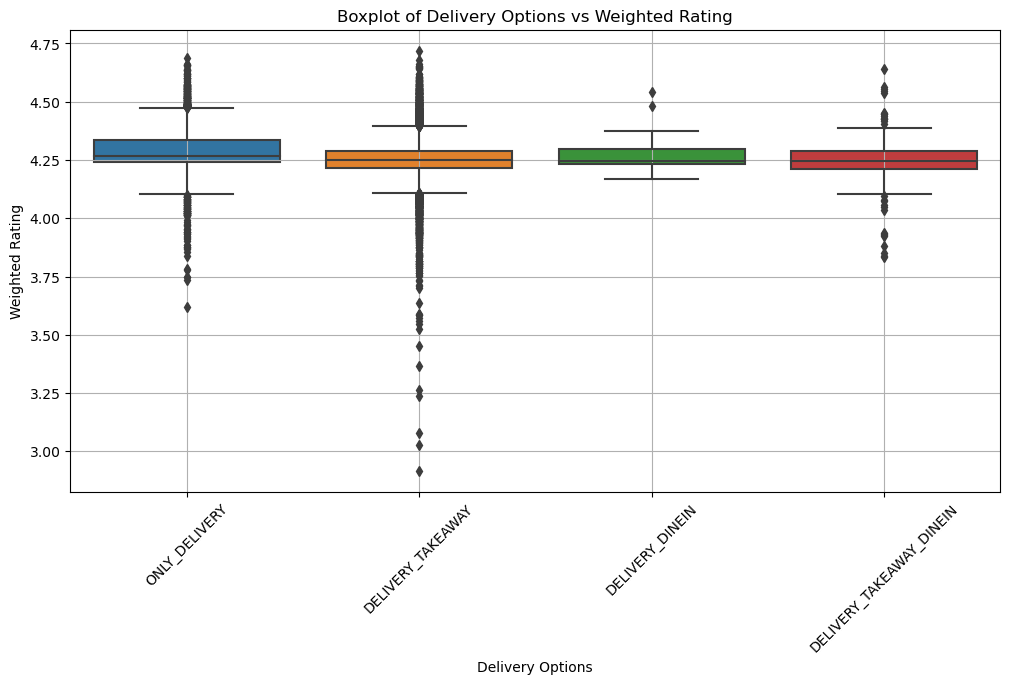

In [10]:
# Boxplot of delivery options versus weighted rating
plt.figure(figsize=(12, 6))
sns.boxplot(x='delivery_options', y='weighted_rating', data=data_final)
plt.title('Boxplot of Delivery Options vs Weighted Rating')
plt.xlabel('Delivery Options')
plt.ylabel('Weighted Rating')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


### Checking for outliers

In [ ]:
# Dataframe to hold non-outlier data for delivery options
data_delivery_no_outliers = pd.DataFrame()

for delivery_option in data_final['delivery_options'].unique():
    subset_indices = data_final[data_final['delivery_options'] == delivery_option].index
    q1 = data_final.loc[subset_indices, 'weighted_rating'].quantile(0.25)
    q3 = data_final.loc[subset_indices, 'weighted_rating'].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    
    # Filter to keep only non-outlier data
    cleaned_data = data_final.loc[(data_final['weighted_rating'] >= lower_bound) & (data_final['weighted_rating'] <= upper_bound) & (data_final['delivery_options'] == delivery_option)]
    
    # Append cleaned data
    data_delivery_no_outliers = pd.concat([data_delivery_no_outliers, cleaned_data], axis=0)

# Display a summary of outliers by delivery options
outlier_summary_delivery = data_delivery_no_outliers.groupby(['delivery_options']).size()
total_by_delivery_option = data_final.groupby(['delivery_options']).size()
outlier_comparison = pd.DataFrame({'Total': total_by_delivery_option, 'Non-Outliers': outlier_summary_delivery})
outlier_comparison['Outliers'] = outlier_comparison['Total'] - outlier_comparison['Non-Outliers']
outlier_comparison['Percentage'] = (outlier_comparison['Outliers'] / outlier_comparison['Total']) * 100
outlier_comparison


### Removing outliers

In [ ]:
# Create a new DataFrame without outliers for more accurate analysis
data_delivery_cleaned = pd.DataFrame()

for delivery_option in data_final['delivery_options'].unique():
    subset_indices = data_final[data_final['delivery_options'] == delivery_option].index
    q1 = data_final.loc[subset_indices, 'weighted_rating'].quantile(0.25)
    q3 = data_final.loc[subset_indices, 'weighted_rating'].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    
    # Filter to keep only non-outlier data
    cleaned_data = data_final.loc[(data_final['weighted_rating'] >= lower_bound) & 
                                  (data_final['weighted_rating'] <= upper_bound) & 
                                  (data_final['delivery_options'] == delivery_option)]
    
    # Append cleaned data
    data_delivery_cleaned = pd.concat([data_delivery_cleaned, cleaned_data], axis=0)

# Perform ANOVA on the cleaned data
anova_model_delivery_cleaned = ols('weighted_rating ~ C(delivery_options)', data=data_delivery_cleaned).fit()
anova_table_delivery_cleaned = sm.stats.anova_lm(anova_model_delivery_cleaned, typ=2)
anova_table_delivery_cleaned


## Evaluation of Relationship: Delivery Options vs Weighted Ratings (After Removing Outliers)

### ANOVA Test on Cleaned Data:
- **F-statistic**: 205.24, which indicates that the differences between group means are highly statistically significant.
- **P-value**: \(8.79 \times 10^{-130}\), which provides extremely strong evidence against the null hypothesis that all delivery option groups have the same mean weighted rating.

### Insights:
- The removal of outliers has refined the dataset, and the results still show highly significant differences in weighted ratings among different delivery options. This suggests that the influence of delivery options on ratings is robust and not driven solely by the presence of outliers.
- The extremely low p-value after outlier removal indicates that differences in delivery options have a strong and consistent impact on customer ratings.

### Recommendations:
- Decision-makers and stakeholders should consider how different delivery methods affect customer satisfaction and tailor their offerings accordingly. This could involve enhancing services or promoting delivery options that correlate with higher customer ratings.
- Further analysis could focus on understanding why certain delivery options perform better, possibly examining aspects like speed, reliability, or customer service interaction.



## Why Use ANOVA: Analysis of Variance

### What is ANOVA?
ANOVA is a statistical method used to compare the means of three or more independent groups to determine if at least one of the group means is statistically different from the others. It's particularly useful when comparing groups based on categorical variables.

### Key Components of ANOVA:
- **Between-Group Variability**: This measures how much the group means differ from the overall mean. A larger between-group variability often indicates a significant effect of the categorical variable on the dependent variable.
- **Within-Group Variability**: This measures variations within each group. If the within-group variability is small, it suggests that the members of each group are similar to each other.

### Why Use ANOVA for `Delivery Options` vs `Weighted Ratings`?
- **Categorical Predictor**: Since `delivery_options` is a categorical variable and `weighted_rating` is a continuous variable, ANOVA is appropriate to test if the mean weighted ratings significantly differ by delivery option.
- **Multiple Groups**: With multiple delivery options, ANOVA allows us to simultaneously test differences across these groups, rather than conducting multiple two-group tests (like t-tests), which increases the risk of type I errors (incorrectly rejecting the null hypothesis).

### Advantages of ANOVA:
- **Efficiency**: It provides a single test for evaluating whether any significant differences exist among the groups, which is more efficient than conducting multiple individual t-tests.
- **Control Over Type I Errors**: ANOVA controls the Type I error rate more effectively when comparing more than two groups.

### How ANOVA Applies to Our Data:
In our dataset, `delivery_options` categorizes restaurants based on how they deliver their service (e.g., delivery only, pickup only, both). ANOVA helps us understand if these categories have different impacts on the customer's perceived quality (weighted ratings), which can influence business strategies such as improving service delivery methods that correlate with higher ratings.

By using ANOVA, we can effectively assess the impact of delivery options on restaurant ratings and make informed decisions based on statistical evidence.


# Location Type vs Ratings

### Calculate the count for **FOOD** and **MART**

In [ ]:
location_type_counts = data['loc_type'].value_counts()
location_type_counts

In [ ]:
# Boxplot of location type versus weighted rating
plt.figure(figsize=(12, 6))
sns.boxplot(x='loc_type', y='weighted_rating', data=data_final)
plt.title('Boxplot of Location Type vs Weighted Rating')
plt.xlabel('Location Type')
plt.ylabel('Weighted Rating')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


In [ ]:
# Calculate the IQR and identify outliers for each location type
outliers = pd.DataFrame()

for loc in data_final['loc_type'].unique():
    subset = data_final[data_final['loc_type'] == loc]
    q1 = subset['weighted_rating'].quantile(0.25)
    q3 = subset['weighted_rating'].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    
    # Filter outliers
    outlier_data = subset[(subset['weighted_rating'] < lower_bound) | (subset['weighted_rating'] > upper_bound)]
    outlier_data['Outlier'] = 'Yes'
    subset['Outlier'] = 'No'
    subset.loc[outlier_data.index, 'Outlier'] = 'Yes'
    
    # Append to the outliers dataframe
    outliers = pd.concat([outliers, subset], axis=0)

# Display a summary of outliers by location type
outlier_summary = outliers.groupby(['loc_type', 'Outlier']).size().unstack(fill_value=0)
outlier_summary['Total'] = outlier_summary.sum(axis=1)
outlier_summary['Percentage'] = (outlier_summary['Yes'] / outlier_summary['Total']) * 100
outlier_summary


In [ ]:
# Remove outliers based on previously identified bounds and re-run ANOVA

# Dataframe to hold non-outlier data
data_no_outliers = pd.DataFrame()

for loc in data_final['loc_type'].unique():
    subset = data_final[data_final['loc_type'] == loc]
    q1 = subset['weighted_rating'].quantile(0.25)
    q3 = subset['weighted_rating'].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    
    # Filter to keep only non-outlier data
    cleaned_data = subset[(subset['weighted_rating'] >= lower_bound) & (subset['weighted_rating'] <= upper_bound)]
    
    # Append cleaned data
    data_no_outliers = pd.concat([data_no_outliers, cleaned_data], axis=0)

# Perform ANOVA on the cleaned data
anova_model_cleaned = ols('weighted_rating ~ C(loc_type)', data=data_no_outliers).fit()
anova_table_cleaned = sm.stats.anova_lm(anova_model_cleaned, typ=2)
anova_table_cleaned


## Evaluation of Relationship: Location Type vs Weighted Ratings (After Removing Outliers)

### ANOVA Test on Cleaned Data:
- **F-statistic**: 118.39, indicating that the differences between group means are statistically significant.
- **P-value**: \(1.92 \times 10^{-27}\), confirming strong evidence against the null hypothesis that all location type groups have the same mean weighted rating, even after outlier removal.

### Insights:
- The results continue to show significant differences in weighted ratings between different location types, even after the removal of outliers. This suggests that the influence of location type on ratings is robust and not driven solely by the presence of outliers.
- The removal of outliers has likely refined the dataset, providing a clearer picture of the true differences between location types without the distortion caused by extreme values.

### Recommendations:
- Decision-makers and stakeholders should consider the characteristics inherent to different location types that might influence customer ratings. This insight could guide improvements or targeted strategies to enhance customer satisfaction.
- Further research could explore what specific aspects of different location types affect ratings more profoundly, potentially focusing on factors like accessibility, amenities, or service quality.


### MSE vs R^2 (Location Type vs Ratings)

In [ ]:
encoder = OneHotEncoder()
# Filtering data to ensure no NaN values in 'rating'
data_filtered_loc_type = data.dropna(subset=['rating'])

# One-hot encoding 'loc_type' after filtering
X_encoded_loc_filtered = encoder.fit_transform(data_filtered_loc_type[['loc_type']]).toarray()
X_encoded_loc_filtered_df = pd.DataFrame(X_encoded_loc_filtered, columns=encoder.get_feature_names_out(['loc_type']))

# Correctly aligned target variable for location type
y_loc_type_filtered = data_filtered_loc_type['rating']

# Splitting the data correctly
X_train_lt_filtered, X_test_lt_filtered, y_train_lt_filtered, y_test_lt_filtered = train_test_split(
    X_encoded_loc_filtered_df, y_loc_type_filtered, test_size=0.2, random_state=42)

# Recreate and fit the linear regression model for location type
model_lt_filtered = LinearRegression()
model_lt_filtered.fit(X_train_lt_filtered, y_train_lt_filtered)

# Predicting ratings with the correctly filtered data
y_pred_lt_filtered = model_lt_filtered.predict(X_test_lt_filtered)

# Recalculate MSE and R² for location type with the correct data alignment
mse_lt_filtered = mean_squared_error(y_test_lt_filtered, y_pred_lt_filtered)
r2_lt_filtered = r2_score(y_test_lt_filtered, y_pred_lt_filtered)

mse_lt_filtered, r2_lt_filtered


The regression model with **Location Type** as predictors achieved a **Mean Squared Error (MSE) of approximately 0.363** and a **Coefficient of Determination (R²) of about 0.0282**. These results suggest a moderate predictive accuracy, with "Location Type" explaining only about 3.51% of the variance in ratings. While there is a slight predictive capability, "Location Type" alone does not strongly predict restaurant ratings, indicating the need for incorporating more variables into the model for improved prediction accuracy.


# Delivery Cost vs Ratings

In [ ]:
# Scatter plot of delivery cost versus weighted rating
plt.figure(figsize=(10, 6))
sns.scatterplot(x='delivery_cost', y='weighted_rating', data=data_delivery_cleaned)
plt.title('Scatter Plot of Delivery Cost vs Weighted Rating')
plt.xlabel('Delivery Cost ($)')
plt.ylabel('Weighted Rating')
plt.grid(True)
plt.show()


### MSE and R^2 Value (Delivery Cost vs Ratings)

In [ ]:
# Remove rows with missing delivery cost
data_delivery_cleaned_filtered = data_delivery_cleaned.dropna(subset=['delivery_cost'])

# Prepare the data again
X_filtered = data_delivery_cleaned_filtered[['delivery_cost']]
y_filtered = data_delivery_cleaned_filtered['weighted_rating']

# Fit the linear regression model again
model_filtered = LinearRegression()
model_filtered.fit(X_filtered, y_filtered)

# Get the slope (coefficient) and intercept
slope_filtered = model_filtered.coef_[0]
intercept_filtered = model_filtered.intercept_

# Predict the ratings
y_pred_filtered = model_filtered.predict(X_filtered)

# Calculate R² value
r_squared_filtered = r2_score(y_filtered, y_pred_filtered)

slope_filtered, intercept_filtered, r_squared_filtered


## Evaluation of Linear Regression Model: Delivery Cost vs Weighted Rating

### Regression Results:
- **Slope (Coefficient)**: \(4.45 \times 10^{-7}\)
  - This coefficient indicates a very weak positive relationship between delivery cost and weighted rating. Essentially, each additional unit of currency spent on delivery cost marginally increases the weighted rating by \(4.45 \times 10^{-7}\) points.
- **Intercept**: 4.257
  - The model predicts a baseline weighted rating of approximately 4.257 in the absence of delivery costs, suggesting a generally positive perception of the services regardless of the delivery cost.
- **R² Value**: \(2.27 \times 10^{-5}\)
  - This value is extremely close to zero, suggesting that the model explains virtually none of the variance in weighted ratings. It indicates that delivery cost is not a significant predictor of weighted ratings.

### Interpretation:
- The very small slope and the negligible R² value suggest that changes in delivery cost have almost no effect on how users rate the services. This indicates that customers do not significantly factor delivery cost into their overall satisfaction or that other variables not considered in this model are far more influential in determining the weighted ratings.

### Conclusion:
- The analysis suggests that while delivery cost is a visible aspect of the service, it does not play a major role in how customers rate the service. This could imply that customers might be more focused on other aspects such as service quality, food quality, or delivery speed when rating the services.

### Recommendations:
- Businesses and service providers should perhaps focus more on improving quality and efficiency rather than adjusting delivery costs to enhance customer satisfaction and ratings.
- Further analysis could include other variables such as delivery time, food quality indicators, or customer service metrics to better understand what influences customer ratings more significantly.


# Top Cuisine vs Ratings

In [ ]:
# Handle NaN values by replacing them with empty lists and reattempt the conversion
data_delivery_cleaned['cuisine_list'] = data_delivery_cleaned['cuisine'].fillna("[]").apply(ast.literal_eval)

# Flatten the list of cuisines into a single list and calculate frequencies again
all_cuisines = [cuisine for sublist in data_delivery_cleaned['cuisine_list'] for cuisine in sublist]
cuisine_series = pd.Series(all_cuisines)
top_cuisines = cuisine_series.value_counts().head(10)  # Get the top 10 cuisines by frequency

top_cuisines


In [ ]:
# Create a mapping of cuisines to their respective weighted ratings
cuisine_ratings = {cuisine: data_delivery_cleaned[data_delivery_cleaned['cuisine_list'].apply(lambda x: cuisine in x)]['weighted_rating'].mean() for cuisine in top_cuisines.index}

# Convert to a DataFrame for easier plotting
cuisine_ratings_df = pd.DataFrame(list(cuisine_ratings.items()), columns=['Cuisine', 'Average Weighted Rating']).sort_values(by='Average Weighted Rating', ascending=False)

# Plot the average weighted ratings for each top cuisine
plt.figure(figsize=(12, 6))
sns.barplot(x='Average Weighted Rating', y='Cuisine', data=cuisine_ratings_df, palette='coolwarm')
plt.title('Average Weighted Ratings for Top Cuisines')
plt.xlabel('Average Weighted Rating')
plt.ylabel('Cuisine')
plt.grid(True)
plt.show()


In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import mean_squared_error

# Initialize the MultiLabelBinarizer
mlb = MultiLabelBinarizer()

# One-hot encode the top cuisines
top_cuisines_list = top_cuisines.index.tolist()
data_delivery_cleaned['top_cuisine_list'] = data_delivery_cleaned['cuisine_list'].apply(
    lambda x: [cuisine for cuisine in x if cuisine in top_cuisines_list]
)
cuisine_encoded = mlb.fit_transform(data_delivery_cleaned['top_cuisine_list'])

# Create a DataFrame from the encoded cuisines
cuisine_encoded_df = pd.DataFrame(cuisine_encoded, columns=mlb.classes_, index=data_delivery_cleaned.index)

# Add the weighted rating to the DataFrame
cuisine_encoded_df['weighted_rating'] = data_delivery_cleaned['weighted_rating']

# Fit a linear regression model
X_cuisines = cuisine_encoded_df.drop('weighted_rating', axis=1)
y_cuisines = cuisine_encoded_df['weighted_rating']
model_cuisines = LinearRegression()
model_cuisines.fit(X_cuisines, y_cuisines)

# Predict the ratings
y_pred_cuisines = model_cuisines.predict(X_cuisines)

# Calculate MSE and R²
mse_cuisines = mean_squared_error(y_cuisines, y_pred_cuisines)
r_squared_cuisines = r2_score(y_cuisines, y_pred_cuisines)

mse_cuisines, r_squared_cuisines


## Statistical Analysis: Top Cuisines vs Weighted Ratings

### Regression Model Results:
- **Mean Squared Error (MSE)**: 0.0035
  - The MSE is relatively low, indicating that the model's predictions are close to the actual ratings on average. However, MSE alone does not reveal the model's explanatory power.
- **R-squared (R²)**: 0.0459
  - The R² value is about 4.59%, which suggests that only a small fraction of the variability in weighted ratings is explained by the cuisine types. This indicates that while cuisine type has some impact, most of the variation in ratings is influenced by other factors not captured by cuisine type alone.

### Interpretation:
- The low R² value implies that other variables, potentially including factors like service quality, restaurant location, price level, or customer expectations, might play a more significant role in influencing weighted ratings than cuisine type does.
- The cuisine type does contribute to the ratings, but its overall impact is limited, suggesting the complexity of factors that customers consider when rating restaurants.

### Conclusion:
- Cuisine type, while relevant, is not the predominant factor driving weighted ratings. Stakeholders should consider a broader range of attributes when attempting to improve customer satisfaction and ratings.

### Recommendations:
- **Broader Analysis**: Further research should include more variables, such as price levels, customer service quality, and location characteristics, to better understand what influences customer ratings.
- **Targeted Improvements**: Focus on enhancing aspects of the dining experience that are more strongly correlated with customer satisfaction, as indicated by more comprehensive modeling.


# Radius vs Rating

In [ ]:
# Scatter plot of radius versus weighted rating
plt.figure(figsize=(10, 6))
sns.scatterplot(x='radius', y='weighted_rating', data=data_delivery_cleaned)
plt.title('Scatter Plot of Radius vs Weighted Rating')
plt.xlabel('Radius (meters)')
plt.ylabel('Weighted Rating')
plt.grid(True)
plt.show()


### MSE and R^2 Value (Radius vs Rating)

In [ ]:
# Prepare the data for regression
X_radius = data_delivery_cleaned[['radius']]  # Predictor
y_radius = data_delivery_cleaned['weighted_rating']  # Response

# Create and train the linear regression model
model_radius = LinearRegression()
model_radius.fit(X_radius, y_radius)

# Get the slope (coefficient) and intercept
slope_radius = model_radius.coef_[0]
intercept_radius = model_radius.intercept_

# Predict the ratings based on the model
y_pred_radius = model_radius.predict(X_radius)

# Calculate MSE and R²
mse_radius = mean_squared_error(y_radius, y_pred_radius)
r_squared_radius = r2_score(y_radius, y_pred_radius)

slope_radius, intercept_radius, mse_radius, r_squared_radius


## Evaluation of Linear Regression Model: Radius vs Weighted Rating

### Regression Results:
- **Slope (Coefficient)**: \(2.61 \times 10^{-7}\)
  - This coefficient suggests a very slight positive relationship between the service radius and weighted ratings. Essentially, as the radius increases, the weighted rating increases very marginally.
- **Intercept**: 4.256
  - The model predicts a baseline weighted rating of approximately 4.256 when the radius is zero, which is hypothetically the default rating in the absence of distance considerations.
- **Mean Squared Error (MSE)**: 0.0037
  - The MSE is low, indicating that the model's predictions are relatively close to the actual ratings.
- **R-squared (R²)**: 0.0007
  - The R² value is extremely low, indicating that the model explains less than 0.1% of the variance in weighted ratings. This implies that the radius of service does not significantly influence how customers rate the services.

### Interpretation:
- The minimal impact of radius on ratings as indicated by the very low R² value suggests that other factors play much more significant roles in influencing customer ratings.
- The radius might not be a primary concern for customers when rating the services, possibly due to expectations that services within a certain range should be consistently good regardless of the specific radius.

### Conclusion:
- While radius might logically seem to impact customer satisfaction due to factors like delivery times or availability, the analysis suggests that its effect on ratings is negligible. This could imply that customers value quality and service over the mere range of service.

### Recommendations:
- Focus on enhancing quality and customer service, which are likely more influential on ratings.
- Consider analyzing other variables such as delivery time, food quality, and customer service interactions, which might provide more insights into what affects customer satisfaction and ratings significantly.


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Encode the 'loc_type' with numeric values for regression analysis
label_encoder = LabelEncoder()
data_delivery_cleaned['loc_type_encoded'] = label_encoder.fit_transform(data_delivery_cleaned['loc_type'])

# Create separate data frames for each location type
unique_loc_types = data_delivery_cleaned['loc_type'].unique()
models = {}
predictions = {}

plt.figure(figsize=(12, 8))

for loc_type in unique_loc_types:
    # Filter data for the current location type
    subset = data_delivery_cleaned[data_delivery_cleaned['loc_type'] == loc_type]
    
    # Prepare the data
    X_loc = subset[['radius']]  # Just using radius for simplicity, could be expanded
    y_loc = subset['weighted_rating']
    
    # Fit the linear regression model
    model = LinearRegression()
    model.fit(X_loc, y_loc)
    models[loc_type] = model  # Store the model
    
    # Predict using the model
    predictions[loc_type] = model.predict(X_loc)
    
    # Plotting
    plt.scatter(X_loc, y_loc, label=f'Data Points: {loc_type}')
    plt.plot(X_loc, predictions[loc_type], label=f'Regression Line: {loc_type}')

plt.title('Linear Regression Lines for Different Location Types vs Weighted Rating')
plt.xlabel('Radius (meters)')
plt.ylabel('Weighted Rating')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import numpy as np

# Plotting the scatter plot and the regression line
plt.figure(figsize=(10, 6))
sns.scatterplot(x='radius', y='weighted_rating', data=data_delivery_cleaned, color='blue', alpha=0.5, label='Data Points')
plt.plot(X_radius, y_pred_radius, color='red', label='Regression Line')  # Plot the regression line

plt.title('Linear Regression: Radius vs Weighted Rating')
plt.xlabel('Radius (meters)')
plt.ylabel('Weighted Rating')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:



# Handle missing values
data['delivery_cost'].fillna(data['delivery_cost'].median(), inplace=True)
data['reviews_nr'].fillna(data['reviews_nr'].median(), inplace=True)
data['delivery_time'].fillna(data['delivery_time'].median(), inplace=True)

# Select predictors and target
predictors = ['delivery_cost', 'radius', 'reviews_nr', 'delivery_time', 'total opening time hours']
X = data[predictors]
y = data['rating']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Ridge Regression
alphas_ridge = [0.01, 0.1, 1, 10, 100]
ridge_results = {}
for alpha in alphas_ridge:
    ridge_model = Ridge(alpha=alpha)
    ridge_model.fit(X_train, y_train)
    y_pred_ridge = ridge_model.predict(X_test)
    mse_ridge = mean_squared_error(y_test, y_pred_ridge)
    r2_ridge = r2_score(y_test, y_pred_ridge)
    ridge_results[alpha] = (mse_ridge, r2_ridge)

# Lasso Regression
alphas_lasso = [0.01, 0.1, 1, 10, 100]
lasso_results = {}
for alpha in alphas_lasso:
    lasso_model = Lasso(alpha=alpha, max_iter=10000)  # Increase max_iter for convergence
    lasso_model.fit(X_train, y_train)
    y_pred_lasso = lasso_model.predict(X_test)
    mse_lasso = mean_squared_error(y_test, y_pred_lasso)
    r2_lasso = r2_score(y_test, y_pred_lasso)
    lasso_results[alpha] = (mse_lasso, r2_lasso, lasso_model.coef_)

# Output results
print("Ridge Results:", ridge_results)
print("Lasso Results:", lasso_results)

# Plotting the results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(range(len(ridge_results)), [v[1] for v in ridge_results.values()], tick_label=[str(k) for k in ridge_results.keys()])
plt.title('Ridge Regression R2 Scores')
plt.xlabel('Alpha')
plt.ylabel('R2 Score')

plt.subplot(1, 2, 2)
plt.bar(range(len(lasso_results)), [v[1] for v in lasso_results.values()], tick_label=[str(k) for k in lasso_results.keys()])
plt.title('Lasso Regression R2 Scores')
plt.xlabel('Alpha')
plt.ylabel('R2 Score')
plt.show()


# Evaluation of Ridge and Lasso Regression Models

## Overview
This analysis evaluates Ridge and Lasso regression models to determine how well they predict restaurant ratings based on various features such as delivery cost, radius, number of reviews, delivery time, and total opening hours. Both models incorporate regularization to prevent overfitting, with Ridge applying L2 regularization and Lasso applying L1 which can set some coefficients to zero.

## Model Performance
- **Ridge Regression** and **Lasso Regression** were tested with alpha values [0.01, 0.1, 1, 10, 100] to explore the impact of regularization strength on model performance.
- Performance was measured using Mean Squared Error (MSE) and R-squared (R²) metrics.

## Results
- **Ridge Regression**: Showed slight improvements in R² with increasing alpha, suggesting a small benefit from regularization in controlling variance.
- **Lasso Regression**: Significant coefficients were reduced, especially at higher alpha values, highlighting feature selection. Performance in terms of R² was generally lower than Ridge, possibly due to the stronger impact of feature elimination.

## Conclusion
- **Ridge** is generally better for this dataset as it consistently shows higher R² scores across all tested alphas.
- **Lasso** might be useful if feature selection is necessary, but it shows a trade-off in performance drop.

## Plotting Results
Below plots show the R² scores for different alphas in Ridge and Lasso regressions. This visual assessment helps in understanding the optimal alpha that balances model complexity and performance.


In [ ]:
# Data for plotting
alphas = [0.01, 0.1, 1, 10, 100]
ridge_r2 = [res[1] for res in ridge_results.values()]
lasso_r2 = [res[1] for res in lasso_results.values()]

plt.figure(figsize=(10, 5))
plt.plot(alphas, ridge_r2, label='Ridge R²', marker='o')
plt.plot(alphas, lasso_r2, label='Lasso R²', marker='x')
plt.xlabel('Alpha')
plt.ylabel('R² Score')
plt.title('Ridge vs Lasso Regression R² Scores by Alpha')
plt.legend()
plt.xscale('log')
plt.show()
